In [73]:
# %% Modules
from haversine import haversine as hs
from scipy.spatial.distance import euclidean as euclidean
import pyproj
from shapely.geometry import Point, LineString
import time
import copy
import osmnx as ox
from datetime import datetime
import geopandas as gpd
import networkx as nx
import momepy as mp
from collections import defaultdict

import pickle


In [74]:
# %% Version check
#Checking that version 1.9.4 is installed. Newer versions cannot run this code as some have depreciated
ox.__version__

'1.9.4'

/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_2393/298859033.py:14: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_graph = ox.graph_from_bbox(north=bbox['max_y'],
/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_2393/298859033.py:14: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osm_graph = ox.graph_from_bbox(north=bbox['max_y'],


Downloaded OSM graph in 6.0s


/var/folders/6b/r5wb08fs0n1ddq3n210r8zzr0000gn/T/ipykernel_2393/298859033.py:31: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_graph = ox.get_undirected(osm_graph)


Graph nodes: 3050, edges: 4485
Graph saved to osm_graph.graphml


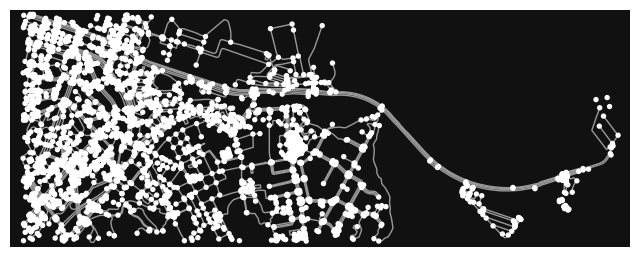

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [77]:
# %% OSMDownloader
#ORIGINAL CODE FROM SOPHIE - Testing on small part of auckland
def OSMDownloader(bbox:dict, filter:str='', retain_all:bool=True, simplify:bool=False, debug:bool=False, 
                    log_file:str='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot.csv',
                    useful_way_tags:list=ox.settings.useful_tags_way, return_directed:bool=False):
    if debug: 
        start = time.time()

    # TEST THIS
    ox.settings.useful_tags_way = useful_way_tags
    #ox.config(useful_tags_way=useful_way_tags)
    
    # will use osm graphs for now. can be converted to gdf. retains road name
    osm_graph = ox.graph_from_bbox(north=bbox['max_y'],
        south=bbox['min_y'], east=bbox['max_x'], west=bbox['min_x'],
        custom_filter=filter, retain_all=retain_all, simplify=simplify)

    if debug:
        print(f'Downloaded OSM graph in {round(time.time() - start, 1)}s')

    # save graph info for future reference
    now = datetime.now()
    min_x, min_y, max_x, max_y, name = bbox['min_x'], bbox['min_y'], bbox['max_x'], bbox['max_y'], bbox['name']
    csv_row = (f'\n{datetime.now()},{name},{min_x},{min_y},{max_x},'
                f'{max_y},{len(osm_graph.nodes)},{len(osm_graph.edges)},')
    with open(log_file, 'a') as fd:
        fd.write(csv_row)

    # I think we always want undirected, but here just in case
    if not return_directed:
        osm_graph = ox.get_undirected(osm_graph)
    
    return osm_graph

# Example bounding box for bike ride - city to Hobson Bay (need to change to all of Auckland later)
bbox = {
    'min_x': 174.766915,  # Minimum longitude
    'min_y': -36.856280,  # Minimum latitude
    'max_x': 174.809491,  # Maximum longitude
    'max_y': -36.843296,  # Maximum latitude
    'name': 'Auckland CBD' # Name of the area
}
ox.settings.cache_folder = '/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot'
# Call the OSMDownloader function
osm_graph = OSMDownloader(
    bbox=bbox,
    filter="['highway']",  # You can adjust the filter as needed
    retain_all=True,
    simplify=True,
    debug=True,
    log_file='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot.csv',
    return_directed=False
)

# Print graph statistics
print(f"Graph nodes: {len(graph.nodes)}, edges: {len(graph.edges)}")

# Save the graph to a file
ox.save_graphml(osm_graph, filepath='/Users/kad/Desktop/cyclists/Kimberley/segmentation/troubleshoot/troubleshoot.graphml')
print("Graph saved to osm_graph.graphml")

ox.plot_graph(osm_graph)

In [78]:
type(osm_graph)

networkx.classes.multigraph.MultiGraph

#### Is the next chunk supposed to use mapmatched points?

In [84]:
# %%  XY Tuples to Points IS THIS SUPPOSED TO BE MAPMATCHED POINTS????
# creates a list of Shapely Point objects from a list of xytuples
def XYsToPoints(xy_tuples:list):
    point_list = []
    for x, y in xy_tuples:
        point_list.append(Point(x, y))
    return point_list


# Getting the coordinates of the nodes - the distance between them drives segementation (pg 6-8 Sophie's Paper)
#looping throught the nodes gdf and extracting the coordinates as tuples
with open('/Users/kad/Desktop/cyclists/Kimberley/mapmatching/mapmatched_tracks/testing', 'rb') as f:
    node_xy_tuples = pickle.load(f) # deserialize using load()
    #print(node_xy_tuples) # print student names

#converting the tupules to poin##ts by calling the XYsToPoints function
node_tuples = XYsToPoints(xy_tuples= node_xy_tuples)

#print(node_tuples)
#type(node_tuples) = LIST

[<POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.769 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.768 -36.854)>, <POINT (174.769 -36.854)>, 

list

In [90]:
# %% Distances From XY List
# calculates haversine distances from previous to current point in a list of tuples
def DistancesFromXYList(xy_tuples:list, distance_args:dict, first_val:any=0):
    distances = [first_val]

    for previous, current in zip(xy_tuples, xy_tuples[1:]):
        #distance = hs((previous[1], previous[0]), (current[1], current[0]), unit=unit)
        distance = DistanceBetweenXYPairs(previous, current, distance_args)
        distances.append(round(distance, distance_args['decimals']))

    return distances

# Distance Between XY Pairs
# calculate distance between two xy points, giving projected or haversine option
def DistanceBetweenXYPairs(xy1:tuple, xy2:tuple, distance_args:dict):

    if distance_args['method'] == 'hs':
        # remember haversine input is order y, x
        dist = hs((xy1[1], xy1[0]), (xy2[1], xy2[0]), unit=distance_args['unit'])

    elif distance_args['method'] == 'proj':
        p = pyproj.Proj(distance_args['epsg'])

        xy1 = p(xy1[0], xy1[1])
        xy2 = p(xy2[0], xy2[1])

        # unit will be whatever the proj unit is
        dist = euclidean(xy1, xy2)
    
    return round(dist, distance_args['decimals'])

distance_args_defined = { #following the structure from config.yml
    "unit": "m",
    "method": "hs",
    "decimals": 2} # don't put speech marks around 2 or it will be interpreted as a string and the round function will not function

haversine_distances = DistancesFromXYList(xy_tuples=node_xy_tuples, distance_args= distance_args_defined)

#print(haversine_distances)
#type(haversine_distances) = list

list

In [93]:
# %% Add Midpoints From Cutoff
# creates new xy tuples between points that have a distance greater than a specified cutoff

# Assuming that src_distances are the distances between points

def AddMidPointsFromCutoff(src_distances:list, src_xytuples:list, cutoff:int):
    
    output_xytuples = []

    for index, distance in enumerate(src_distances):
        # calculate midpoint if distance between points is greater than cutoff
        if distance > cutoff:
            cur_geom = src_xytuples[index]
            prv_geom = src_xytuples[index - 1]

            # midpoint formula (basic linear algebra)
            interpolated_x = (prv_geom[0] + cur_geom[0]) / 2
            interpolated_y = (prv_geom[1] + cur_geom[1]) / 2

            output_xytuples.append((interpolated_x, interpolated_y))

        # make sure to add back the non-interpolated points
        output_xytuples.append(src_xytuples[index])

    return output_xytuples

midpoints = AddMidPointsFromCutoff(src_distances = haversine_distances, src_xytuples = node_xy_tuples, cutoff = 10)

#print(type(midpoints)) = list
#print(midpoints)


<class 'list'>
[(174.768617, -36.85406), (174.768567, -36.854005), (174.768593, -36.854034), (174.768586, -36.854026), (174.76859, -36.85403), (174.7686, -36.854042), (174.76859, -36.854031), (174.768594, -36.854035), (174.768603, -36.854045), (174.768594, -36.854035), (174.768608, -36.854051), (174.768616, -36.854059), (174.768614, -36.854056), (174.768619, -36.854062), (174.768618, -36.854061), (174.768618, -36.854061), (174.768618, -36.854061), (174.7685015, -36.8541235), (174.768385, -36.854186), (174.768391, -36.854194), (174.768398, -36.854203), (174.768403, -36.854209), (174.768404, -36.854211), (174.768396, -36.8542), (174.768401, -36.854206), (174.768407, -36.854214), (174.768417, -36.854226), (174.768425, -36.854236), (174.76843, -36.854243), (174.768431, -36.854243), (174.768438, -36.854253), (174.76844, -36.854255), (174.768445, -36.854262), (174.768449, -36.854266), (174.768454, -36.854273), (174.768473, -36.854297), (174.768486, -36.854312), (174.768507, -36.854339), (174

In [95]:
# %%
# Get Edge Directions
# defines analysis direction of ways in a network
#   - finds northernmost node, then calculates bearing from that node to other
#   - if bearing is positive, assign one direction, if negative assign another
def GetEdgeDirections(cur_graph:nx.MultiDiGraph, undirected:bool=True, labels:list=['A', 'B'], 
                        return_colours:bool=False, colours:list=['blue', 'green'], 
                        debug:bool=False, identifier:str='osmid'):
    
    w_graph = copy.deepcopy(cur_graph)  # never work on source graph

    if debug:
        start = time.time()
    
    geodesic = pyproj.Geod(ellps='WGS84')  # used for bearing calculation

    # needs testing on both. default to be undirected
    if undirected:
        w_graph = w_graph.to_undirected()

    nodes = w_graph.nodes(data=True)
    way_id = 0  # simple enumeration for way id
    label_colours = []  # colours are useful when opening in a GIS for rule-based styles

    # iterate over edges with data. apply changes directly to data dict of graph
    for u, v, data in w_graph.edges(data=True):
        # save xy values for u and v nodes of way
        u_x, u_y = nodes[u]['x'], nodes[u]['y']
        v_x, v_y = nodes[v]['x'], nodes[v]['y']

        # get northernmost node simply by the highest u latitude value
        #   then calculate bearing to figure out direction
        if u_y > v_y:
            north_node = 'u'
            fwd_azimuth, bwd_azimuth, dist = geodesic.inv(u_x, u_y, v_x, v_y)
        else:  # both if v < u AND if u = v
            north_node = 'v'
            fwd_azimuth, bwd_azimuth, dist = geodesic.inv(v_x, v_y, u_x, u_y)
        
        # if the forward azimuth is positive, set to direction A, otherwise B
        if int(fwd_azimuth) > 0:
            direction = 'A'
            label_colours.append(colours[0])
        else:
            direction = 'B'
            label_colours.append(colours[1])

        data['north_node'] = north_node
        data['bearing'] = int(fwd_azimuth)
        data['direction'] = direction
        data['way_id'] = way_id if identifier == 'custom' else data['osmid']
        
        way_id += 1

    if debug:
        print(f'Calculated direction for {len(w_graph.edges)} ways in {round(time.time() - start, 1)}s')
    
    if return_colours:
        return w_graph, label_colours
    else:
        return w_graph

    
edge_directions = GetEdgeDirections(cur_graph = osm_graph, undirected = True,labels=['A','B'], return_colours = False, colours = ['blue', 'green'], debug = True)
print(edge_directions)
type(edge_directions)

Calculated direction for 4485 ways in 0.7s
MultiGraph with 3050 nodes and 4485 edges


networkx.classes.multigraph.MultiGraph

In [98]:
print("Sample edge attributes:")
sample_edge = list(edge_directions.edges(data=True))[437]  # Get the first edge
print(sample_edge)

Sample edge attributes:
(25773727, 540465689, {'osmid': 7637203, 'name': 'Alberon Place', 'highway': 'residential', 'maxspeed': '50', 'oneway': False, 'reversed': False, 'length': 2.617, 'from': 540465689, 'to': 25773727, 'geometry': <LINESTRING (174.786 -36.855, 174.786 -36.855)>, 'north_node': 'u', 'bearing': 176, 'direction': 'A', 'way_id': 7637203})


In [106]:
# %% This produces an edge ID now
def SegmentEdges(cur_graph:nx.MultiDiGraph, segment_length:int, method:str, debug:bool=False, 
                    midpoint_cutoff:float=0.1, distance_args:dict={'unit':'m','method':'hs','decimals':2},
                    add_num:bool=False):

    w_graph = copy.deepcopy(cur_graph)

    # debug just prints time taken
    if debug:
        start = time.time()
    
    #graph = graph.copy()  # do this to seperate analysis from original graph
    nodes = w_graph.nodes(data=True)  # do this because its cleaner than writing it out each time u and v are accessed

    edge_id = 0  # simple numbering for identifier
    for u, v, data in w_graph.edges(data=True):
        edge_id += 1

        # save xy values for u and v nodes of way
        u_x, u_y = nodes[u]['x'], nodes[u]['y']
        v_x, v_y = nodes[v]['x'], nodes[v]['y']

        # change orientation of processing based on direction attribute
        if data['direction'] == 'A':
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
        elif data['direction'] == 'B':
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y

        '''# need to create a proper order here
        x1, y1 = nodes[data['from']]['x'], nodes[data['from']]['y']
        x2, y2 = nodes[data['to']]['x'], nodes[data['to']]['y']'''

        # just keeping this for legacy purposes. I don't expect anyone to ever use midpoint
        if method == 'midpoint':
            # start with distance of 0 as we are calculating distance from previous
            way_geom = [(x1, y1), (x2, y2)]
            way_distances = DistancesFromXYList(way_geom, distance_args)  # this gives the same value as data['length'] but since I made the function might as well be consistent
            
            if not way_distances[1] < segment_length:
                while max(way_distances) > midpoint_cutoff:
                    way_geom = AddMidPointsFromCutoff(way_distances, way_geom, midpoint_cutoff)
                    way_distances = DistancesFromXYList(way_geom, distance_args)

                # assign segments based on cumulative distance between midpoints
                # segment structure: list of (x1, y1), (x2, y2), segment ID, length
                cur_seg_len = 0
                cur_seg_id = 0
                start_geom = way_geom[0]
                segments = []

                for index, distance in enumerate(way_distances):
                    cur_seg_len += distance

                    if cur_seg_len > segment_length:
                        end_geom = way_geom[index]
                        cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                        segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]

                        # reset segment values
                        segments.append(segment)
                        cur_seg_len = 0
                        cur_seg_id += 1
                        start_geom = end_geom
                    
                    elif index == len(way_distances) - 1:  
                        # add remainder
                        end_geom = way_geom[index]
                        cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                        segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                        segments.append(segment)
                
            else:  # if segment length is greater than length of way
                cur_seg_uid = str(edge_id) + '-' + str(0)
                segments = [[way_geom[0], way_geom[1], 0, cur_seg_uid, way_distances[1]]]
            
            # consolidate data
            data['segments'] = segments
            data['edge_id'] = edge_id
        
        elif method == 'interpolate':
            cur_seg_id = 0
            #cur_seg_uid = str(data['way_id']) + '-' + str(cur_seg_id)
            cur_seg_len = 0
            segments = []

            d = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)

            while d > segment_length:
                
                t = segment_length / d
                end_x, end_y = (((1 - t) * x1 + t * x2), ((1 - t) * y1 + t * y2))
                cur_seg_len = DistanceBetweenXYPairs((x1, y1), (end_x, end_y), distance_args)

                # save segment info
                start_geom = (x1, y1)
                end_geom = (end_x, end_y)
                cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                segments.append(segment)
                
                # reset segment values
                cur_seg_id += 1
                d = DistanceBetweenXYPairs((x2, y2), (end_x, end_y), distance_args)
                x1, y1 = end_x, end_y
            
            # if remaining distance is less than the segment length
            else:
                # check if only 1 segment in edge. if not, use the end points from previous segment as start points for this segment
                if cur_seg_id != 0:
                    x1, y1 = end_x, end_y
                
                cur_seg_len = DistanceBetweenXYPairs((x1, y1), (x2, y2), distance_args)
                
                # save segment info
                start_geom = (x1, y1)
                end_geom = (x2, y2)
                cur_seg_uid = str(edge_id) + '-' + str(cur_seg_id)
                segment = [start_geom, end_geom, cur_seg_id, cur_seg_uid, cur_seg_len]
                segments.append(segment)
                
                # add
                cur_seg_id += 1
                
            data['segments'] = segments
            data['edge_id'] = edge_id

    if debug:
        print(f'Segmented {len(w_graph.edges)} ways at {segment_length}m in {round(time.time() - start, 1)}s')
    
    return w_graph  

segment_edges_graph = SegmentEdges(cur_graph = edge_directions, segment_length= 5, method = "interpolate")
#5 used for segment_length this is in the config file

print(type(segment_edges_graph))
print(segment_edges_graph)

<class 'networkx.classes.multigraph.MultiGraph'>
MultiGraph with 3050 nodes and 4485 edges


In [104]:
print("Sample edge attributes:")
segment_edges_graph_sample_edge = list(segment_edges_graph.edges(data=True))[0]  # Get the first edge
print(segment_edges_graph_sample_edge)

Sample edge attributes:
(25769626, 4330750496, {'osmid': 907165030, 'lanes': '4', 'name': 'Symonds Street', 'highway': 'secondary', 'maxspeed': '30', 'oneway': False, 'reversed': False, 'length': 66.51, 'from': 4330750496, 'to': 25769626, 'geometry': <LINESTRING (174.767 -36.855, 174.767 -36.855)>, 'north_node': 'u', 'bearing': -137, 'direction': 'B', 'way_id': 907165030, 'segments': [[(174.7669854, -36.8552602), (174.76702344691023, -36.85522710723199), 0, '1-0', 5.0], [(174.76702344691023, -36.85522710723199), (174.76706149382045, -36.85519401446399), 1, '1-1', 5.0], [(174.76706149382045, -36.85519401446399), (174.76709954073067, -36.85516092169598), 2, '1-2', 5.0], [(174.76709954073067, -36.85516092169598), (174.76713758764092, -36.855127828927984), 3, '1-3', 5.0], [(174.76713758764092, -36.855127828927984), (174.76717563455117, -36.85509473615998), 4, '1-4', 5.0], [(174.76717563455117, -36.85509473615998), (174.7672136814614, -36.85506164339197), 5, '1-5', 5.0], [(174.7672136814614

In [ ]:
# %% AHHHH I Am confused
# Simple Assigning of Points to Segments 
# assigns points to segment based on simple spatial join
#   - this method is problematic for several reasons, see the code notes for more information
#   - input tracks as dictionaries, do conversion in the function
#   - segments input as gdf
def SimplePointsToSegs(segments_gdf:gpd.GeoDataFrame, tracks:dict, in_prefix:str='match_', debug:bool=False):

    w_tracks_dict = copy.deepcopy(tracks)

    # debug variables
    multimatch_sjoin_count = 0
    total_point_count = 0

    for track in w_tracks_dict.values():
        # create index for dealing with multiple sjoin outputs
        index = [i for i in range(0, len(track[f'{in_prefix}geometry']))]

        # convert matched geometry to gdf for sjoin operation
        #container = {'index': index, 'geometry': track[f'{in_prefix}geometry'], 'xy_tuples': track[f'{in_prefix}xy_tuple']}
        container = {'index': index, 'geometry': track[f'{in_prefix}geometry']}
        track_geom_gdf = gpd.GeoDataFrame(container, crs='EPSG:4326')

        joined = track_geom_gdf.sjoin_nearest(segments_gdf, how='left')

        if debug:
            multimatch_sjoin_count += (len(joined) - len(index))
            total_point_count += len(index)

        # remove duplicates, convert to dict, add to input dict copy
        joined_noduplicates = joined.groupby('index').first()
        joined_dict = joined_noduplicates.to_dict(orient='list')
        for col in list(segments_gdf.columns):
            track[col] = joined_dict[col].copy()

    if debug:
        return w_tracks_dict, multimatch_sjoin_count, total_point_count
    else:
        return w_tracks_dict

segments_graph_gdf = ox.convert.graph_to_gdfs(graph, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

#unpickling the mapmatched tracks 
with open('/Users/kad/Desktop/cyclists/Kimberley/mapmatching/osrm_caller/matched_tracksTEST', 'rb') as file:
    map_matched_tracks = pickle.load(file)


Points_to_segments = SimplePointsToSegs(segments_gdf = segments_graph_gdf, tracks = map_matched_tracks)

In [ ]:
Points_to_segments

In [ ]:
# %% Get Terminating Nodes
# Gets nodes that have a degree of 1 (and therefore represent the end of a road)
#   - can also sort by latitude
def GetTerminatingNodes(graph, return_data=False, debug=False, order_by_north=True):
    startend_points = []
    for node in graph.nodes(data=True):
        if graph.degree(node[0]) == 1:
            startend_points.append(node)

    if order_by_north:
        startend_points.sort(key=lambda x: x[1]['y'], reverse=True)

    return startend_points




# Remove Edges Without Attribute
# Removes edges that do not contain an input attribute
def RemoveEdgesWithoutAttribute(graph, attribute, debug=False, remove_isolates=True):
    w_graph = copy.deepcopy(graph)

    count_rmedges = 0
    for u, v, data in list(w_graph.edges(data=True)):
        if attribute not in data or data[attribute] == 'not available':
            w_graph.remove_edge(u, v)
            count_rmedges += 1

    isolates = list(nx.isolates(w_graph))
    count_rmnodes = len(isolates)
    w_graph.remove_nodes_from(isolates)

    if debug:
        print(f'Removed {count_rmnodes} nodes and {count_rmedges} edges for missing attribute "{attribute}"')

    return w_graph

In [107]:
# %% Order Segment Graph
# Assigns order to segments/graph edges based on depth-first search
def OrderSegmentGraph(cur_graph:nx.MultiDiGraph, out_attribute='seg_pos_on_way', 
                      group_attribute='name', debug=False,
                        add_numbering=False):

    w_graph = copy.deepcopy(cur_graph)
    w_graph = w_graph.to_undirected()

    if debug:
        start = time.time()
    
    # Step 1: remove ways that don't have names (and relevant nodes)
    w_graph = RemoveEdgesWithoutAttribute(w_graph, group_attribute)

    
    # Inspect the type and value of data[group_attribute]
    #for u, v, data in w_graph.edges(data=True):
     #   print(f"data[group_attribute] = {data[group_attribute]}")  # Check the value
    
    # Step 2: group ways by road name
    edges_by_road = {}
    for u, v, data in w_graph.edges(data=True):
        # Check if group_attribute is actually a string, if not, extract the first element of the list
        group_value = data[group_attribute] if isinstance(data[group_attribute], str) else data[group_attribute][0]

        # Add to dictionary, using group_value as the key
        if group_value in edges_by_road:
            edges_by_road[group_value].append((u, v, 0))
        else:
            edges_by_road[group_value] = [(u, v, 0)]
            
    


    # Step 3: obtain subgraph for grouped ways
    # .copy() means data is retained
    # have to create actual graph rather than subgraph to avoid connection issues between ways
    all_subgraphs = [nx.MultiDiGraph(w_graph.edge_subgraph(edges_by_road[name]).copy()).to_undirected() for name in edges_by_road]

    if add_numbering:
        way_num = 0
    
   # Step 4: find connected subgraphs
    from collections import defaultdict

    # Step 4: find connected subgraphs
    for subgraph in all_subgraphs:

        way_cons = [i for i in nx.connected_components(subgraph)]

        # Initialize a dictionary to store groups based on edge names
        name_groups = defaultdict(list)

        # for each set of connections within a subgraph
        for i, connections in enumerate(way_cons):
            if add_numbering:
                way_num += 1

            # add custom ref attribute
            first_edge = list(subgraph.edges(data=True))[0]

            # Debugging print statement to check the structure
            print(f"First edge: {first_edge}")

            # Check if 'name' is a list or a single string
            if isinstance(first_edge[2], dict) and 'name' in first_edge[2]:
                edge_names = first_edge[2]['name']
                if isinstance(edge_names, list):  # If 'name' is a list, group by all names
                    custom_ref = '_'.join(edge_names) + '_' + str(i)  # Join multiple names with '_'
                else:
                    custom_ref = edge_names + '_' + str(i)
            else:
                # If it's not a dictionary or 'name' is not found, handle it differently
                print(f"Warning: Edge does not have a 'name' attribute. Using alternative custom_ref.")
                custom_ref = f"custom_ref_{i}"

            # Add the edge to the group dictionary, using the name(s) as the key
            name_groups[custom_ref].append(first_edge)

        # Now you have the edges grouped by their custom name
        print(f"Grouped edges based on names: {dict(name_groups)}")

        # Create graph from subgraph connections, grouped by name
        for group, edges in name_groups.items():
            # Process each group of edges (you can use 'edges' as needed)
            way_graph = nx.MultiDiGraph(subgraph.subgraph([e[0] for e in edges] + [e[1] for e in edges]).copy()).to_undirected()

            startend_points = GetTerminatingNodes(way_graph)


        # Proceed with the rest of the processing...


            #ox.plot_graph(way_graph)

            '''# if there is only one node (edge)
            if way_lgraph.number_of_nodes() == 1:
                # set output attribute to 0 (as there is only one edge to form a path to/from anyway)
                edge = list(way_lgraph.nodes())[0]
                w_graph[edge[0]][edge[1]][0][out_attribute] = 0'''

            if len(startend_points) > 0:  # if startend points are found, use the northernmost of those
                source = startend_points[0][0]
            else:  # otherwise, use the northenmost of any node in the subgraph
                northernmost_node = None
                for node in way_graph.nodes(data=True):
                    if northernmost_node == None:
                        northernmost_node = node
                    else:
                        if node[1]['y'] > northernmost_node[1]['y']:
                            northernmost_node = node
                source = node[0]
                
            # perform depth-first search along edges in graph, assign labels based on order of search
            edge_order = nx.edge_dfs(way_graph, source=source)
            edge_labels = [(edge, number) for number, edge in enumerate(edge_order)]
            for edge, number in edge_labels:
                w_graph[edge[0]][edge[1]][0][out_attribute] = number
                w_graph[edge[0]][edge[1]][0]['custom_ref'] = custom_ref

                if add_numbering:
                    w_graph[edge[0]][edge[1]][0]['way_number'] = way_num

        if len(way_cons) == 0:
            print(way_graph.edges)

    if debug:
        print(f'Ordered {len(w_graph.edges)} edges in {round(time.time() - start, 1)}s')
    
    return w_graph

Ordered_seg_graph = OrderSegmentGraph(cur_graph=segment_edges_graph)

First edge: (9451582789, 25769966, {'osmid': 623912214, 'lanes': '4', 'name': 'Symonds Street', 'highway': 'secondary', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 16.738, 'from': 9451582789, 'to': 25769966, 'geometry': <LINESTRING (174.77 -36.852, 174.77 -36.852)>, 'north_node': 'v', 'bearing': -137, 'direction': 'B', 'way_id': 623912214, 'segments': [[(174.7704628, -36.8517945), (174.7704251357228, -36.851827863201905), 0, '25-0', 5.0], [(174.7704251357228, -36.851827863201905), (174.77038747144564, -36.85186122640382), 1, '25-1', 5.0], [(174.77038747144564, -36.85186122640382), (174.77034980716846, -36.851894589605735), 2, '25-2', 5.0], [(174.77034980716846, -36.851894589605735), (174.7703367, -36.8519062), 3, '25-3', 1.74]], 'edge_id': 25})
Grouped edges based on names: {'Symonds Street_0': [(9451582789, 25769966, {'osmid': 623912214, 'lanes': '4', 'name': 'Symonds Street', 'highway': 'secondary', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 16.

In [109]:
print(Ordered_seg_graph)
type(Ordered_seg_graph)

MultiGraph with 1149 nodes and 1265 edges


networkx.classes.multigraph.MultiGraph

In [108]:
print("Sample edge attributes:")
ordered_seg_sample_edge = list(Ordered_seg_graph.edges(data=True))[17]  # Get the first edge
print(ordered_seg_sample_edge)


Sample edge attributes:
(25769953, 7704010117, {'osmid': [1191569433, 150576247], 'oneway': False, 'name': 'Fort Street', 'highway': 'living_street', 'maxspeed': ['10', '30'], 'reversed': True, 'length': 32.579, 'geometry': <LINESTRING (174.767 -36.846, 174.767 -36.846, 174.767 -36.846)>, 'from': 7704010117, 'to': 25769953, 'north_node': 'u', 'bearing': 104, 'direction': 'A', 'way_id': [1191569433, 150576247], 'segments': [[(174.7670566, -36.8459976), (174.76711091246162, -36.846009125475746), 0, '19-0', 5.0], [(174.76711091246162, -36.846009125475746), (174.76716522492325, -36.8460206509515), 1, '19-1', 5.0], [(174.76716522492325, -36.8460206509515), (174.7672195373849, -36.84603217642726), 2, '19-2', 5.0], [(174.7672195373849, -36.84603217642726), (174.76727384984656, -36.846043701903014), 3, '19-3', 5.0], [(174.76727384984656, -36.846043701903014), (174.7673281623082, -36.84605522737877), 4, '19-4', 5.0], [(174.7673281623082, -36.84605522737877), (174.76738247476982, -36.84606675285

In [124]:
# Segment GeoDataFrame From Graph
# THIS ONLY WORKS ON THE SEGMENTED GRAPH, NOT THE GRAPH PRODUCED FROM SEGMENTS
# creates geodataframe of segments from a (spatially segmented) networkx graph
def SegGDFFromGraph(graph:nx.MultiDiGraph, segment_length:int, colours:list=['blue', 'red'], 
                    notfound_val:any='not available'):
    container = {
        # way attributes
        'way_name': [],
        'way_highway': [],
        'way_surface': [],
        'way_maxspeed': [],
        'way_number': [],
        # edgegroup attributes
        'edgegroup_id': [],
        # edge attributes
        'edge_osmid': [],
        'edge_order': [],
        # segment attributes
        'geometry': [],
        'seg_uid': [],
        'seg_id': [],
        'seg_group': [],
        'seg_order': [],
        'seg_length': [],
        'seg_roundingerror': [],
    }

    for index, (u, v, data) in enumerate(graph.edges(data=True)):
        try:
            for start_xy, end_xy, seg_id, seg_uid, seg_grp, seg_order, edge_grp, length in data['segments']:
                seg_geom = LineString([Point(start_xy), Point(end_xy)])

                # way attributes
                # not all ways have these attributes so have to check
                container['way_surface'].append(data['surface'] if 'surface' in data else notfound_val)
                container['way_maxspeed'].append(data['maxspeed'] if 'maxspeed' in data else notfound_val)
                container['way_name'].append(data['name'] if 'name' in data else notfound_val)
                container['way_highway'].append(data['highway'])
                container['way_number'].append(data['way_number'])

                # edgegroup attributes
                container['edgegroup_id'].append(edge_grp)

                # edge attributes
                container['edge_osmid'].append(data['osmid'])
                container['edge_order'].append(data['order_on_road'])

                # segment attributes
                container['seg_id'].append(seg_id)
                container['seg_uid'].append(seg_uid)
                container['seg_group'].append(seg_grp)  # fix 11/06/23
                container['geometry'].append(seg_geom)
                container['seg_length'].append(length)
                container['seg_roundingerror'].append(length - segment_length)  # not sure if this works
                container['seg_order'].append(seg_order)

                
                # set colour based on odd/even segment 
                #container['colour'].append(colours[0] if seg_id % 2 == 0 else colours[1])
                print(container)
        except:
            print(f'Segments not found in edge: {u}, {v}')

    gdf = gpd.GeoDataFrame(container)
    return gdf

Segment_gdf = SegGDFFromGraph(graph = Ordered_seg_graph, segment_length = 5)

Segments not found in edge: 25769626, 4330750496
Segments not found in edge: 25769626, 4320687376
Segments not found in edge: 25769626, 1661804576
Segments not found in edge: 25769945, 7210067109
Segments not found in edge: 25769945, 7210067104
Segments not found in edge: 25769945, 7210067124
Segments not found in edge: 25769945, 7210067105
Segments not found in edge: 25769945, 7210067103
Segments not found in edge: 25769947, 683777432
Segments not found in edge: 25769947, 3740805160
Segments not found in edge: 25769947, 9451580693
Segments not found in edge: 25769948, 683777432
Segments not found in edge: 25769948, 9451580703
Segments not found in edge: 25769948, 25769949
Segments not found in edge: 25769949, 7210067103
Segments not found in edge: 25769949, 9451580716
Segments not found in edge: 25769953, 1666840344
Segments not found in edge: 25769953, 7704010117
Segments not found in edge: 25769965, 4322912686
Segments not found in edge: 25769965, 12041045968
Segments not found in e

In [125]:
def SegGDFFromGraph(graph:nx.MultiDiGraph, segment_length:int, colours:list=['blue', 'red'], 
                    notfound_val:any='not available'):
    container = {
        # way attributes
        'way_name': [],
        'way_highway': [],
        'way_surface': [],
        'way_maxspeed': [],
        'way_number': [],
        # edgegroup attributes
        'edgegroup_id': [],
        # edge attributes
        'edge_osmid': [],
        'edge_order': [],
        # segment attributes
        'geometry': [],
        'seg_uid': [],
        'seg_id': [],
        'seg_group': [],
        'seg_order': [],
        'seg_length': [],
        'seg_roundingerror': [],
        'colour': []  # Add color field here
    }

    for index, (u, v, data) in enumerate(graph.edges(data=True)):
        try:
            for start_xy, end_xy, seg_id, seg_uid, seg_grp, seg_order, edge_grp, length in data['segments']:
                seg_geom = LineString([Point(start_xy), Point(end_xy)])

                # way attributes
                container['way_surface'].append(data.get('surface', notfound_val))
                container['way_maxspeed'].append(data.get('maxspeed', notfound_val))
                container['way_name'].append(data.get('name', notfound_val))
                container['way_highway'].append(data['highway'])
                container['way_number'].append(data.get('way_number', notfound_val))

                # edgegroup attributes
                container['edgegroup_id'].append(edge_grp)

                # edge attributes
                container['edge_osmid'].append(data['osmid'])
                container['edge_order'].append(data.get('order_on_road', notfound_val))

                # segment attributes
                container['seg_id'].append(seg_id)
                container['seg_uid'].append(seg_uid)
                container['seg_group'].append(seg_grp)  
                container['geometry'].append(seg_geom)
                container['seg_length'].append(length)
                container['seg_roundingerror'].append(length - segment_length) 

                # set colour based on odd/even segment 
                container['colour'].append(colours[0] if seg_id % 2 == 0 else colours[1])

        except Exception as e:
            print(f'Error processing edge ({u}, {v}): {e}')

    gdf = gpd.GeoDataFrame(container)
    return gdf

Segment_gdf = SegGDFFromGraph(graph = Ordered_seg_graph, segment_length = 5)


Error processing edge (25769626, 4330750496): not enough values to unpack (expected 8, got 5)
Error processing edge (25769626, 4320687376): not enough values to unpack (expected 8, got 5)
Error processing edge (25769626, 1661804576): not enough values to unpack (expected 8, got 5)
Error processing edge (25769945, 7210067109): not enough values to unpack (expected 8, got 5)
Error processing edge (25769945, 7210067104): not enough values to unpack (expected 8, got 5)
Error processing edge (25769945, 7210067124): not enough values to unpack (expected 8, got 5)
Error processing edge (25769945, 7210067105): not enough values to unpack (expected 8, got 5)
Error processing edge (25769945, 7210067103): not enough values to unpack (expected 8, got 5)
Error processing edge (25769947, 683777432): not enough values to unpack (expected 8, got 5)
Error processing edge (25769947, 3740805160): not enough values to unpack (expected 8, got 5)
Error processing edge (25769947, 9451580693): not enough valu

In [142]:
def SegGDFFromGraph(graph:nx.MultiDiGraph, segment_length:int, colours:list=['blue', 'red'], 
                    notfound_val:any='not available'):
    container = {
        # way attributes
        'way_name': [],
        'way_highway': [],
        'way_surface': [],
        'way_maxspeed': [],
        'way_number': [],
        # edgegroup attributes
        'edgegroup_id': [],
        # edge attributes
        'edge_osmid': [],
        'edge_order': [],
        # segment attributes
        'geometry': [],
        'seg_uid': [],
        'seg_id': [],
        'seg_group': [],
        'seg_order': [],
        'seg_length': [],
        'seg_roundingerror': [],
        'colour': []  # Add color field here
    }

    for index, (u, v, data) in enumerate(graph.edges(data=True)):
        try:
            for segment in data['segments']:
                # Ensure the segment has the correct number of elements
                if len(segment) == 8:
                    start_xy, end_xy, seg_id, seg_uid, seg_grp, seg_order, edge_grp, length = segment
                elif len(segment) == 5:
                    # If there are only 5 elements, assign defaults for missing values
                    start_xy, end_xy, seg_id, seg_uid, seg_grp = segment
                    seg_order, edge_grp, length = None, None, None  # Assign None or appropriate default

                seg_geom = LineString([Point(start_xy), Point(end_xy)])

                # Append data to the container lists
                container['way_surface'].append(data.get('surface', notfound_val))
                container['way_maxspeed'].append(data.get('maxspeed', notfound_val))
                container['way_name'].append(data.get('name', notfound_val))
                container['way_highway'].append(data['highway'])
                container['way_number'].append(data.get('way_number', notfound_val))

                container['edgegroup_id'].append(edge_grp)
                container['edge_osmid'].append(data['osmid'])
                container['edge_order'].append(data.get('order_on_road', notfound_val))

                container['seg_id'].append(seg_id)
                container['seg_uid'].append(seg_uid)
                container['seg_group'].append(seg_grp)  
                container['geometry'].append(seg_geom)
                container['seg_length'].append(length)

                # Check if length is valid (not None) before calculating rounding error
                if length is not None:
                    container['seg_roundingerror'].append(length - segment_length)
                else:
                    container['seg_roundingerror'].append(None)  # Or any other default value

                # Ensure seg_order is always appended
                container['seg_order'].append(seg_order if seg_order is not None else -1)  # Use -1 or appropriate default

                # Set colour based on odd/even segment
                container['colour'].append(colours[0] if seg_id % 2 == 0 else colours[1])

        except Exception as e:
            print(f'Error processing edge ({u}, {v}): {e}')
    
    # Check if all lists in container have the same length
    list_lengths = {key: len(value) for key, value in container.items()}
    #print(f"List lengths: {list_lengths}")

    # Check if all lists have the same length before creating the GeoDataFrame
    if len(set(list_lengths.values())) > 1:
        raise ValueError("Not all lists in the container have the same length.")
    

    gdf = gpd.GeoDataFrame(container)
    return gdf

Segment_gdf = SegGDFFromGraph(graph = Ordered_seg_graph, segment_length = 5)


way_name: ['Symonds Street', 'Symonds Street', 'Symonds Street', 'Symonds Street', 'Symonds Street']
way_highway: ['secondary', 'secondary', 'secondary', 'secondary', 'secondary']
way_surface: ['not available', 'not available', 'not available', 'not available', 'not available']
way_maxspeed: ['30', '30', '30', '30', '30']
way_number: ['not available', 'not available', 'not available', 'not available', 'not available']
edgegroup_id: [None, None, None, None, None]
edge_osmid: [907165030, 907165030, 907165030, 907165030, 907165030]
edge_order: ['not available', 'not available', 'not available', 'not available', 'not available']
geometry: [<LINESTRING (174.767 -36.855, 174.767 -36.855)>, <LINESTRING (174.767 -36.855, 174.767 -36.855)>, <LINESTRING (174.767 -36.855, 174.767 -36.855)>, <LINESTRING (174.767 -36.855, 174.767 -36.855)>, <LINESTRING (174.767 -36.855, 174.767 -36.855)>]
seg_uid: ['1-0', '1-1', '1-2', '1-3', '1-4']
seg_id: [0, 1, 2, 3, 4]
seg_group: [5.0, 5.0, 5.0, 5.0, 5.0]
seg_o

In [143]:
Segment_gdf.head(5)



,way_name,way_highway,way_surface,way_maxspeed,way_number,edgegroup_id,edge_osmid,edge_order,geometry,seg_uid,seg_id,seg_group,seg_order,seg_length,seg_roundingerror,colour
0,Symonds Street,secondary,not available,30,not available,None,907165030,not available,"LINESTRING (174.76699 -36.85526, 174.76702 -36...",1-0,0,5.0,-1,None,None,blue
1,Symonds Street,secondary,not available,30,not available,None,907165030,not available,"LINESTRING (174.76702 -36.85523, 174.76706 -36...",1-1,1,5.0,-1,None,None,red
2,Symonds Street,secondary,not available,30,not available,None,907165030,not available,"LINESTRING (174.76706 -36.85519, 174.76710 -36...",1-2,2,5.0,-1,None,None,blue
3,Symonds Street,secondary,not available,30,not available,None,907165030,not available,"LINESTRING (174.76710 -36.85516, 174.76714 -36...",1-3,3,5.0,-1,None,None,red
4,Symonds Street,secondary,not available,30,not available,None,907165030,not available,"LINESTRING (174.76714 -36.85513, 174.76718 -36...",1-4,4,5.0,-1,None,None,blue


In [121]:
# Validate Segment
# Checks that the u/v node geometry matches up with the first/last points in segment list
def ValidateSegment(graph, node_start, node_end, segments):
    node_start_info = graph.nodes[node_start]
    node_end_info = graph.nodes[node_end]

    node_start_loc = (node_start_info['x'], node_start_info['y'])
    node_end_loc = (node_end_info['x'], node_end_info['y'])

    start_at_start = segments[0][0] == node_start_loc
    start_at_end = segments[0][0] == node_end_loc

    end_at_start = segments[-1][1] == node_start_loc
    end_at_end = segments[-1][1] == node_end_loc

    if start_at_start and end_at_end:
        return 1
    elif start_at_end and end_at_start:
        return -1
    else:
        return 0


# Graph From Segments
# Create graph from lists of segments, ignoring previous graph geometry
def GraphFromSegments(segmented_graph, debug=False):

    out_graph = nx.MultiDiGraph()
    out_graph.graph['crs'] = 'epsg:4326'  # needed to do osmnx operations

    for u, v, data in list(segmented_graph.edges(data=True)):
        segments = data['segments']

        # ensure that segmetns are geometrically valid
        direction = ValidateSegment(segmented_graph, u, v, segments)
        # if the segments are not valid, skip this edge
        if direction == 0:
            if debug:
                print(f'Skipping edge {u} -> {v}')
            continue  # what does this do?

        # this code was written by David Wu, I need to check with them about it
        boundary_nodes = [None, u, v]
        intermediate_node_names = [f"SEGNODE_{seg_id}" for _, _, _, seg_id, *_ in segments[:-1]]
        node_list = [boundary_nodes[direction], *intermediate_node_names, boundary_nodes[-direction]]
        # add in start node, will overwrite if already exists
        out_graph.add_node(node_list[0], **segmented_graph.nodes[node_list[0]])

        for node_A, node_B, seg_info in zip(node_list[:-1], node_list[1:], segments):
            loc_A, loc_B, seg_order, seg_id, seg_len = seg_info

            edge_name = f'{node_A}-{node_B}'
            seg_uid = f"{data['osmid']}_{data['edge_id']}_{seg_order}"
            seg_id = f"{data['edge_id']}-{seg_order}"

            # add end node for each new segment
            out_graph.add_node(node_B, **segmented_graph.nodes.get(node_B, {'x': loc_B[0], 'y': loc_B[1]}))

            out_graph.add_edge(node_A, node_B, 0, seg_uid=seg_uid, seg_length=seg_len, seg_order=seg_order, 
                        edge_id=data['edge_id'], osmid=data['osmid'], seg_id=seg_id, 
                        name=data['name'] if 'name' in data else None)

    return out_graph

graph_from_segments = GraphFromSegments(Ordered_seg_graph, debug=False)

In [122]:
print("Sample edge attributes:")
graph_from_segments_sample_edge = list(graph_from_segments.edges(data=True))[17]  # Get the first edge
print(graph_from_segments_sample_edge)


Sample edge attributes:
('SEGNODE_2-1', 4320687376, {'seg_uid': '1183559173_2_2', 'seg_length': 1.78, 'seg_order': 2, 'edge_id': 2, 'osmid': 1183559173, 'seg_id': '2-2', 'name': 'Mount Street'})


In [ ]:
# convert u/v points to xy1,xy2 based on input direction
def UVtoXYs(u_x, u_y, v_x, v_y, direction):
    # u to v
    if direction == 'uv':
        x1, y1 = u_x, u_y
        x2, y2 = v_x, v_y
    # v to u
    elif direction == 'vu':
        x1, y1 = v_x, v_y
        x2, y2 = u_x, u_y
    # north to south
    elif direction == 'n':
        if u_y < v_y:
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y
        else:
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
    # south to north
    elif direction == 's':      
        if u_y > v_y:
            x1, y1 = v_x, v_y
            x2, y2 = u_x, u_y
        else:
            x1, y1 = u_x, u_y
            x2, y2 = v_x, v_y
        
    return x1, x2, y1, y2


# function to make editing easier
def GetSegIDs(way_num, seg_num, seg_index, group_num, order, method='name'):
    #seg_uid = '{}_{}_{}_{}'.format(name, osmid, seg_num, index)

    seg_id = '{}-{}'.format(seg_num, seg_index)
    
    seg_uid = '{}-{}-{}_{}-{}'.format(way_num, group_num, order, seg_num, seg_index)

    if method == 'name':
        #seg_group = '{}-{}-{}'.format(way_num, group_num, seg_num)
        seg_group = '{}-{}-{}'.format(way_num, order, seg_num)
    else:
        seg_group = '{}-{}'.format(group_num, seg_num)
    # waynum_groupnum_order-segnum_segindex
    return seg_id, seg_uid, seg_group


def GetAttributeEdgeGroups():
    pass

def GetTopoEdgeGroups():
    pass
 